In [1]:
!pip install image-classifiers
import os
import tensorflow as tf
from keras import callbacks, Model
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import optimizers
from keras.utils.io_utils import HDF5Matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import random

%matplotlib inline

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Imprimindo algumas imagens da base de treinamento

In [8]:
random.seed(42)

sample_datagen = ImageDataGenerator(rescale=1./255)
base_path = 'fruits-360'
target_size = (100, 100)

sample_generator = sample_datagen.flow_from_directory(base_path + '/Training',
                                                      target_size=target_size,
                                                      batch_size=25,
                                                      class_mode="sparse")

Found 57276 images belonging to 114 classes.


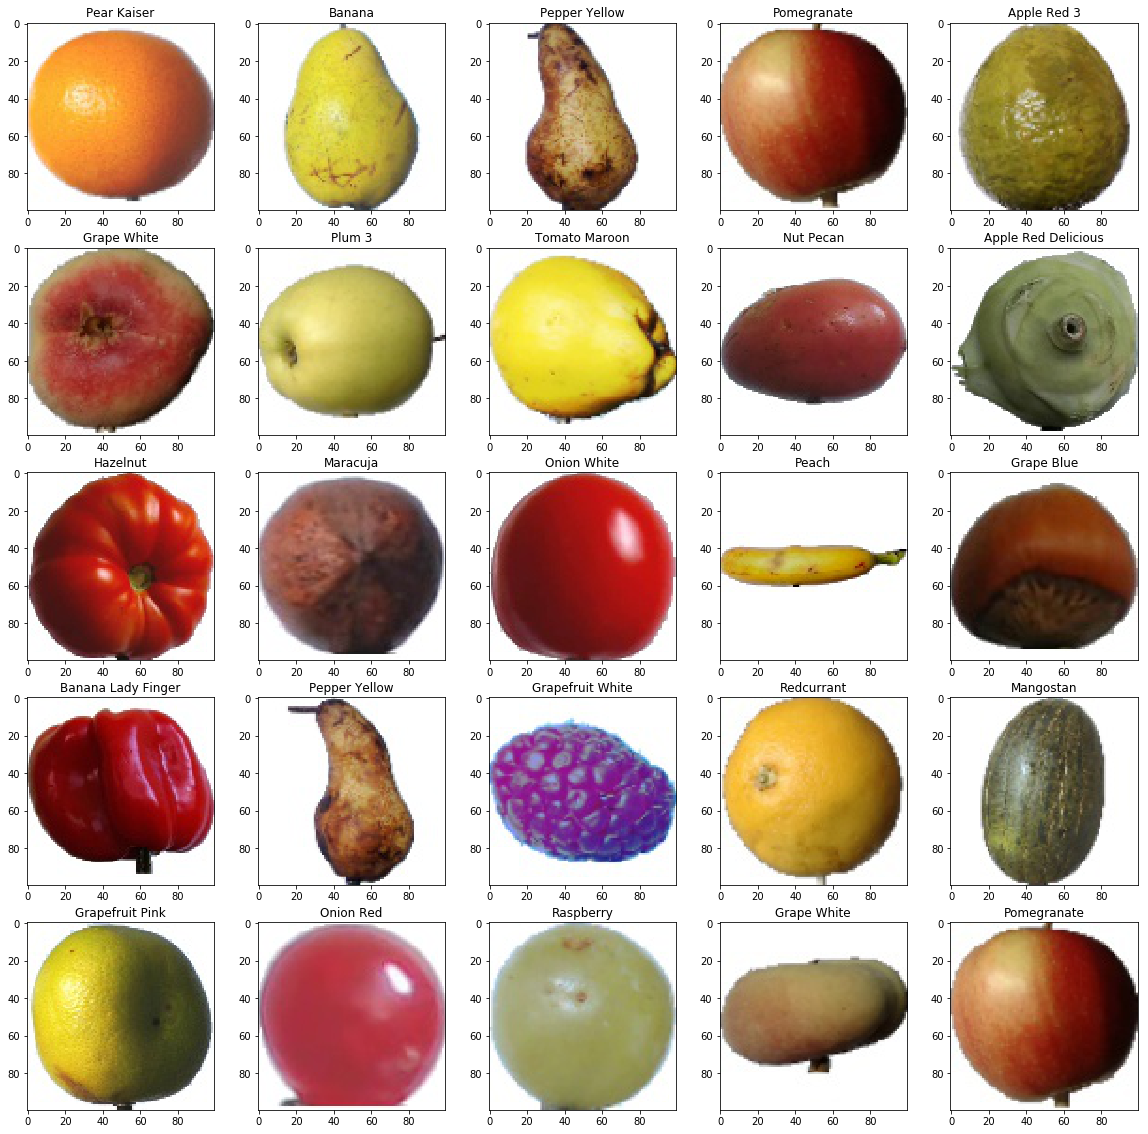

In [36]:
classes = ["Apple Braeburn", "Carambula,Huckleberry", "Orange","Plum 3",
"Apple Crimson Snow", "Cherry 1", "Kaki","Papaya","Pomegranate",
"Apple Golden 1", "Cherry 2", "Kiwi","Passion Fruit", "Pomelo Sweetie",
"Apple Golden 2", "Cherry Rainier", "Kohlrabi","Peach", "Potato Red Washed",
"Apple Golden 3", "Cherry Wax Black", "Kumquats","Peach 2", "Potato White",
"Apple Granny Smith", "Cherry Wax Red", "Lemon", "Peach Flat","Quince",
"Apple Pink Lady","Cherry Wax Yellow","Lemon Meyer", "Pear","Rambutan",
"Apple Red 1","Chestnut", "Limes", "Pear Abate","Raspberry",
"Apple Red 2","Clementine", "Lychee","Pear Kaiser", "Redcurrant",
"Apple Red 3","Cocos","Mandarine", "Pear Monster","Salak",
"Apple Red Delicious","Dates,Mango", "Pear Red","Strawberry",
"Apple Red Yellow 1", "Ginger Root","Mango Red", "Pear Williams", "Strawberry Wedge",
"Apple Red Yellow 2", "Granadilla", "Mangostan", "Pepino","Tamarillo",
"Apricot","Grape Blue", "Maracuja","Pepper Green","Tangelo",
"Avocado","Grape Pink", "Melon Piel de Sapo","Pepper Red","Tomato 1",
"Avocado ripe", "Grape White","Mulberry","Pepper Yellow", "Tomato 2",
"Banana", "Grape White 2","Nectarine", "Physalis","Tomato 3",
"Banana Lady Finger", "Grape White 3","Nectarine Flat","Physalis with Husk","Tomato 4",
"Banana Red", "Grape White 4","Nut Forest","Pineapple", "Tomato Cherry Red",
"Blueberry","Grapefruit Pink","Nut Pecan", "Pineapple Mini","Tomato Maroon",
"Cactus fruit", "Grapefruit White", "Onion Red", "Pitahaya Red","Tomato Yellow",
"Cantaloupe 1", "Guava","Onion Red Peeled","Plum,Walnut",
"Cantaloupe 2", "Hazelnut", "Onion White", "Plum 2"]

x_sample, y_sample = sample_generator.next()
plt.rcParams['figure.figsize'] = (20,20)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_sample[i])
    plt.title("{}".format(classes[int(y_sample[i])]))

# Carregando as imagens da base treino e testes
##Utilizaremos 20% da base de treinamento para validação

In [37]:
batch_size = 60

train_datagen = ImageDataGenerator(rescale = 1./255,validation_split = 0.2)
train_generator = train_datagen.flow_from_directory(base_path + "/Training",
                                                    target_size = target_size,
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    subset = 'training')

validation_generator = train_datagen.flow_from_directory(base_path + "/Training",
                                                         target_size = target_size,
                                                         batch_size = batch_size,
                                                         class_mode = "categorical",
                                                         subset ='validation')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(base_path + "/Test",
                                                  target_size = target_size,
                                                  batch_size = batch_size,
                                                  class_mode = "categorical")

Found 45852 images belonging to 114 classes.
Found 11424 images belonging to 114 classes.
Found 19548 images belonging to 114 classes.


# Parâmetros para treinamento e validação

In [38]:
rms = optimizers.RMSprop(lr = 0.0002,
                         decay = 1e-6)

device = '/gpu:0'

epochs = 4

train_steps = train_generator.samples / batch_size

validation_steps = validation_generator.samples / batch_size 

test_steps = test_generator.samples / batch_size

patience = epochs // 3

# Funções de auxílio

In [39]:
df_resultado = pd.DataFrame(columns=["Rede", "train_acc", "val_acc"])
def salvar_resultado(rede, train_acc, val_acc, df):
    df = df.append({"Rede" : rede,
                    "train_acc" : train_acc,
                    "val_acc" : val_acc}, 
                   ignore_index = True)
    return df

In [40]:
def train_model(model, train_g = train_generator, validation_g = validation_generator):
  with tf.device(device):
      return model.fit_generator(generator = train_g,
                                 steps_per_epoch = train_steps,
                                 epochs = epochs,
                                 verbose = 1,
                                 validation_data = validation_g,
                                 validation_steps = validation_steps,
                                 callbacks=[callbacks.TerminateOnNaN(),
                                            callbacks.ReduceLROnPlateau(patience = patience),
                                            callbacks.EarlyStopping(patience = patience,
                                                                    restore_best_weights = True,
                                                                    verbose = 1)])

In [41]:
import seaborn as sns

def acc_loss_model(history_model):
  
  history = pd.DataFrame(history_model.history)

  plt.figure(figsize=(16, 6))
  plt.subplot(121)
  sns.lineplot(data=history[['loss', 'val_loss']])

  plt.subplot(122)
  sns.lineplot(data=history[['acc', 'val_acc']]);

In [42]:
def evaluate_model(model):
  score_train = model.evaluate_generator(generator = train_generator,
                                         steps = train_steps)

  score_val = model.evaluate_generator(generator = validation_generator,
                                       steps = validation_steps)

# Rede *Homemade*

## Definindo a rede

In [45]:
home_made = Sequential()

home_made.add(Conv2D(filters = 10,
                     kernel_size = [3, 3],
                     name = "conv_1",
                     activation = "relu",
                     input_shape = [100, 100, 3]))

home_made.add(MaxPool2D(pool_size = [2, 2],
                        name = "pool_1"))

home_made.add(Conv2D(filters = 20,
                     kernel_size = [3, 3],
                     name = "conv_2",
                     activation = "relu"))

home_made.add(Dropout(rate = 0.5,
                      name = "do_1"))

home_made.add(MaxPool2D(pool_size = [2, 2],
                        name = "pool_2"))

home_made.add(Flatten())

home_made.add(Dense(units = 114,
                    name = "dense_1",
                    activation = 'softmax'))

home_made.compile(optimizer = rms,
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

home_made.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 98, 98, 10)        280       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 49, 49, 10)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 47, 47, 20)        1820      
_________________________________________________________________
do_1 (Dropout)               (None, 47, 47, 20)        0         
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 23, 23, 20)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10580)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 114)               1206234   
Total para

## Treinando o modelo

In [46]:
history_home_made = train_model(home_made)

Epoch 1/4
765/764 [==============================] - 81s 105ms/step - loss: 0.9207 - acc: 0.7735 - val_loss: 0.6580 - val_acc: 0.8471
Epoch 2/4
765/764 [==============================] - 79s 103ms/step - loss: 0.0674 - acc: 0.9817 - val_loss: 0.4302 - val_acc: 0.8989
Epoch 3/4
765/764 [==============================] - 79s 104ms/step - loss: 0.0198 - acc: 0.9946 - val_loss: 0.3975 - val_acc: 0.9119
Epoch 4/4
765/764 [==============================] - 79s 104ms/step - loss: 0.0084 - acc: 0.9977 - val_loss: 0.4356 - val_acc: 0.8973
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping


## Imprimindo resultado do treinamento

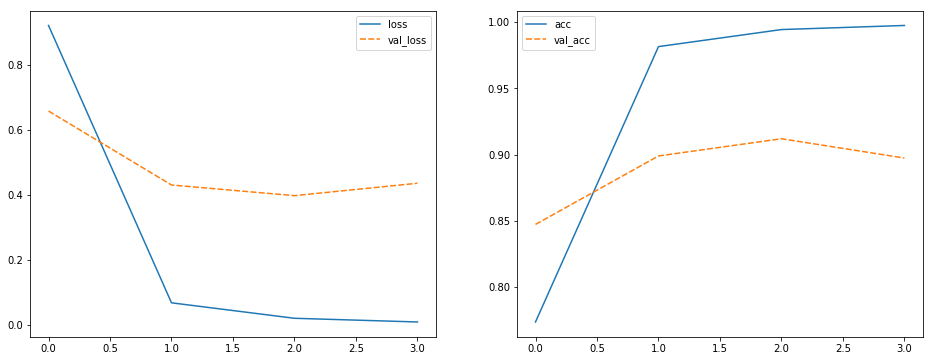

In [47]:
acc_loss_model(history_home_made)

In [48]:
evaluate_model(home_made)

# ResNet18 - Transfer Learning

## Feature Extraction

In [52]:
!pip install image-classifiers
from classification_models.resnet import ResNet18, preprocess_input

ResNet18_model = ResNet18(input_shape = (100,100,3),
                          weights = "imagenet",
                          include_top=False)

for layer in ResNet18_model.layers:
    layer.trainable = False

output = ResNet18_model.output

output = Flatten(name = 'flat_mdc')(output)

output = Dense(114,
               activation ='softmax',
               name = 'saida_mdc')(output)

ResNet18_model = Model(inputs = ResNet18_model.input,
                       outputs = output)

ResNet18_model.compile(loss ='categorical_crossentropy',
                       optimizer = rms,
                       metrics=['accuracy'])

ResNet18_model.summary()

mxnet-model-server 1.0.1 requires model-archiver, which is not installed.
autovizwidget 0.12.7 has requirement plotly<3.0,>=1.10.0, but you'll have plotly 3.6.1 which is incompatible.
chainermn 1.3.1 has requirement chainer<5.0,>=3.5.0, but you'll have chainer 5.2.0 which is incompatible.
azure-datalake-store 0.0.41 has requirement requests>=2.20.0, but you'll have requests 2.18.4 which is incompatible.
flake8 3.7.5 has requirement pycodestyle<2.6.0,>=2.5.0, but you'll have pycodestyle 2.4.0 which is incompatible.
blobxfer 1.6.0 has requirement requests~=2.21.0, but you'll have requests 2.18.4 which is incompatible.
blobxfer 1.6.0 has requirement ruamel.yaml~=0.15.85, but you'll have ruamel-yaml 0.15.35 which is incompatible.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 100, 100, 3)  0            

### Treinando o modelo

In [53]:
with tf.device(device):
    history_frozen = ResNet18_model.fit_generator(generator = train_generator,
                                                  steps_per_epoch = train_steps,
                                                  epochs = epochs,
                                                  verbose = 1,
                                                  validation_data = validation_generator,
                                                  validation_steps = validation_steps,
                                                  callbacks=[callbacks.TerminateOnNaN(),
                                                             callbacks.ReduceLROnPlateau(patience = patience),
                                                             callbacks.EarlyStopping(patience = patience,
                                                                                     restore_best_weights = True,
                                                                                     verbose = 1)])

Epoch 1/4
765/764 [==============================] - 258s 337ms/step - loss: 1.2677 - acc: 0.7398 - val_loss: 4.9542 - val_acc: 0.0087
Epoch 2/4
765/764 [==============================] - 257s 336ms/step - loss: 0.0503 - acc: 0.9934 - val_loss: 5.0840 - val_acc: 0.0083
Restoring model weights from the end of the best epoch
Epoch 00002: early stopping


### Imprimindo resultado do treinamento

In [ ]:
import seaborn as sns

history = pd.DataFrame(history_frozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = ResNet18_model.evaluate_generator(generator = train_generator,
                                                steps = validation_steps)

score_val = ResNet18_model.evaluate_generator(generator = validation_generator,
                                              steps = validation_steps)

score_test = ResNet18_model.evaluate_generator(generator = test_generator,
                                               steps = test_steps)

df_resultado = salvar_resultado(rede = "ResNet18 - Feature Extraction",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

## Fine Tuning

In [ ]:
for layer in ResNet18_model.layers:
    layer.trainable = True

ResNet18_model.compile(loss ='categorical_crossentropy',
                       optimizer = rms,
                       metrics=['accuracy'])

ResNet18_model.summary()

### Treinando o modelo

In [ ]:
with tf.device(device):
    history_unfrozen = ResNet18_model.fit_generator(generator = train_generator,
                                                    steps_per_epoch = steps_per_epoch,
                                                    epochs = epochs,
                                                    verbose = 1,
                                                    validation_data = validation_generator,
                                                    validation_steps = validation_steps,
                                                    callbacks=[callbacks.TerminateOnNaN(),
                                                               callbacks.ReduceLROnPlateau(patience = patience),
                                                               callbacks.EarlyStopping(patience = patience,
                                                                                       restore_best_weights = True,
                                                                                       verbose = 1)])

### Imprimindo resultado do treinamento

In [ ]:
import seaborn as sns

history = pd.DataFrame(history_unfrozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = ResNet18_model.evaluate_generator(generator = train_generator,
                                                steps = validation_steps)

score_val = ResNet18_model.evaluate_generator(generator = validation_generator,
                                              steps = validation_steps)

score_test = ResNet18_model.evaluate_generator(generator = test_generator,
                                               steps = test_steps)

df_resultado = salvar_resultado(rede = "ResNet18 - Fine Tuning",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

# VGG16 - Transfer Learning

## Feature Extraction

In [ ]:
from keras.layers import Input
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

VGG16_model = VGG16(input_shape = (96,96,3),
                    weights = "imagenet",
                    include_top = False)

for layer in VGG16_model.layers:
    layer.trainable = False

output = VGG16_model.output

output = Flatten(name = 'flat_mdc')(output)

output = Dense(103,
               activation ='softmax',
               name = 'saida_mdc')(output)

VGG16_model = Model(inputs = VGG16_model.input,
                    outputs = output)

VGG16_model.compile(loss ='categorical_crossentropy',
                        optimizer = rms,
                        metrics=['accuracy'])

VGG16_model.summary()

### Treinando o modelo

In [ ]:
with tf.device(device):
    history_frozen = VGG16_model.fit_generator(generator = train_generator,
                                               steps_per_epoch = steps_per_epoch,
                                               epochs = epochs,
                                               verbose = 1,
                                               validation_data = validation_generator,
                                               validation_steps = validation_steps,
                                               callbacks=[callbacks.TerminateOnNaN(),
                                                          callbacks.ReduceLROnPlateau(patience = patience),
                                                          callbacks.EarlyStopping(patience = patience,
                                                                                  restore_best_weights = True,
                                                                                  verbose = 1)])

### Imprimindo resultado do treinamento

In [ ]:
import seaborn as sns

history = pd.DataFrame(history_frozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = VGG16_model.evaluate_generator(generator = train_generator,
                                             steps = validation_steps)

score_val = VGG16_model.evaluate_generator(generator = validation_generator,
                                           steps = validation_steps)

score_test = VGG16_model.evaluate_generator(generator = test_generator,
                                            steps = test_steps)

df_resultado = salvar_resultado(rede = "VGG16 - Feature Extraction",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

## Fine Tuning

In [ ]:
for layer in VGG16_model.layers:
    layer.trainable = True

VGG16_model.compile(loss ='categorical_crossentropy',
                    optimizer = rms,
                    metrics=['accuracy'])

VGG16_model.summary()

### Treinando o modelo

In [ ]:
with tf.device(device):
    history_unfrozen = VGG16_model.fit_generator(generator = train_generator,
                                                 steps_per_epoch = steps_per_epoch,
                                                 epochs = epochs,
                                                 verbose = 1,
                                                 validation_data = validation_generator,
                                                 validation_steps = validation_steps,
                                                 callbacks=[callbacks.TerminateOnNaN(),
                                                            callbacks.ReduceLROnPlateau(patience = patience),
                                                            callbacks.EarlyStopping(patience = patience,
                                                                                    restore_best_weights = True,
                                                                                    verbose = 1)])

### Imprimindo resultado do treinamento

In [ ]:
import seaborn as sns

history = pd.DataFrame(history_unfrozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = VGG16_model.evaluate_generator(generator = train_generator,
                                             steps = validation_steps)

score_val = VGG16_model.evaluate_generator(generator = validation_generator,
                                           steps = validation_steps)

score_test = VGG16_model.evaluate_generator(generator = test_generator,
                                            steps = test_steps)

df_resultado = salvar_resultado(rede = "VGG16 - Fine Tuning",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

# InceptionV3 - Transfer Learning

## Feature Extraction

In [ ]:
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

InceptionV3_model = InceptionV3(input_shape = (96,96,3),
                                weights = "imagenet",
                                include_top = False)

for layer in InceptionV3_model.layers:
    layer.trainable = False

output = InceptionV3_model.output

output = Flatten(name = 'flat_mdc')(output)

output = Dense(103,
               activation ='softmax',
               name = 'saida_mdc')(output)

InceptionV3_model = Model(inputs = InceptionV3_model.input,
                          outputs = output)

InceptionV3_model.compile(loss ='categorical_crossentropy',
                          optimizer = rms,
                          metrics=['accuracy'])

InceptionV3_model.summary()

### Treinando o modelo

In [ ]:
with tf.device(device):
    history_frozen = InceptionV3_model.fit_generator(generator = train_generator,
                                                     steps_per_epoch = steps_per_epoch,
                                                     epochs = epochs,
                                                     verbose = 1,
                                                     validation_data = validation_generator,
                                                     validation_steps = validation_steps,
                                                     callbacks=[callbacks.TerminateOnNaN(),
                                                                callbacks.ReduceLROnPlateau(patience = patience),
                                                                callbacks.EarlyStopping(patience = patience,
                                                                                        restore_best_weights = True,
                                                                                        verbose = 1)])

### Imprimindo resultado do treinamento

In [ ]:
import seaborn as sns

history = pd.DataFrame(history_frozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = InceptionV3_model.evaluate_generator(generator = train_generator,
                                                   steps = validation_steps)

score_val = InceptionV3_model.evaluate_generator(generator = validation_generator,
                                                 steps = validation_steps)

score_test = InceptionV3_model.evaluate_generator(generator = test_generator,
                                                  steps = test_steps)

df_resultado = salvar_resultado(rede = "InceptionV3 - Feature Extraction",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

## Fine Tuning

In [ ]:
for layer in InceptionV3_model.layers:
    layer.trainable = True

InceptionV3_model.compile(loss ='categorical_crossentropy',
                          optimizer = rms,
                          metrics=['accuracy'])

InceptionV3_model.summary()

### Treinando o modelo

In [ ]:
with tf.device(device):
    history_unfrozen = InceptionV3_model.fit_generator(generator = train_generator,
                                                       steps_per_epoch = steps_per_epoch,
                                                       epochs = epochs,
                                                       verbose = 1,
                                                       validation_data = validation_generator,
                                                       validation_steps = validation_steps,
                                                       callbacks=[callbacks.TerminateOnNaN(),
                                                                  callbacks.ReduceLROnPlateau(patience = patience),
                                                                  callbacks.EarlyStopping(patience = patience,
                                                                                          restore_best_weights = True,
                                                                                          verbose = 1)])

### Imprimindo resultado do treinamento

In [ ]:
import seaborn as sns

history = pd.DataFrame(history_unfrozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = InceptionV3_model.evaluate_generator(generator = train_generator,
                                                   steps = validation_steps)

score_val = InceptionV3_model.evaluate_generator(generator = validation_generator,
                                                 steps = validation_steps)

score_test = InceptionV3_model.evaluate_generator(generator = test_generator,
                                                  steps = test_steps)

df_resultado = salvar_resultado(rede = "InceptionV3 - Fine Tuning",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

# MobileNetV2 - Transfer Learning

## Feature Extraction

In [ ]:
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

MobileNet_model = MobileNetV2(input_shape = (96,96,3),
                              weights = "imagenet",
                              include_top = False)

for layer in MobileNet_model.layers:
    layer.trainable = False

output = MobileNet_model.output

output = Flatten(name = 'flat_mdc')(output)

output = Dense(103,
               activation ='softmax',
               name = 'saida_mdc')(output)

MobileNet_model = Model(inputs = MobileNet_model.input,
                        outputs = output)

MobileNet_model.compile(loss ='categorical_crossentropy',
                        optimizer = rms,
                        metrics=['accuracy'])

MobileNet_model.summary()

### Treinando o modelo

In [ ]:
with tf.device(device):
    history_frozen = MobileNet_model.fit_generator(generator = train_generator,
                                                   steps_per_epoch = steps_per_epoch,
                                                   epochs = epochs,
                                                   verbose = 1,
                                                   validation_data = validation_generator,
                                                   validation_steps = validation_steps,
                                                   callbacks=[callbacks.TerminateOnNaN(),
                                                              callbacks.ReduceLROnPlateau(patience = patience),
                                                              callbacks.EarlyStopping(patience = patience,
                                                                                      restore_best_weights = True,
                                                                                      verbose = 1)])

### Imprimindo resultado do treinamento

In [ ]:
import seaborn as sns

history = pd.DataFrame(history_frozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = MobileNet_model.evaluate_generator(generator = train_generator,
                                                 steps = validation_steps)

score_val = MobileNet_model.evaluate_generator(generator = validation_generator,
                                               steps = validation_steps)

score_test = MobileNet_model.evaluate_generator(generator = test_generator,
                                                steps = test_steps)

df_resultado = salvar_resultado(rede = "MobileNet - Feature Extraction",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

## Fine Tuning

In [ ]:
for layer in MobileNet_model.layers:
    layer.trainable = True

MobileNet_model.compile(loss ='categorical_crossentropy',
                        optimizer = rms,
                        metrics=['accuracy'])

MobileNet_model.summary()

### Treinando o modelo

In [ ]:
with tf.device(device):
    history_unfrozen = MobileNet_model.fit_generator(generator = train_generator,
                                                     steps_per_epoch = steps_per_epoch,
                                                     epochs = epochs,
                                                     verbose = 1,
                                                     validation_data = validation_generator,
                                                     validation_steps = validation_steps,
                                                     callbacks=[callbacks.TerminateOnNaN(),
                                                                callbacks.ReduceLROnPlateau(patience = patience),
                                                                callbacks.EarlyStopping(patience = patience,
                                                                                        restore_best_weights = True,
                                                                                        verbose = 1)])

### Imprimindo resultado do treinamento

In [ ]:
import seaborn as sns

history = pd.DataFrame(history_unfrozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = MobileNet_model.evaluate_generator(generator = train_generator,
                                                 steps = validation_steps)

score_val = MobileNet_model.evaluate_generator(generator = validation_generator,
                                               steps = validation_steps)

score_test = MobileNet_model.evaluate_generator(generator = test_generator,
                                                steps = test_steps)

df_resultado = salvar_resultado(rede = "MobileNet - Fine Tuning",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

In [ ]:
df_resultado.sort_values(by=["Rede"])